

### MNIST Introduction

[The MNIST](http://yann.lecun.com/exdb/mnist/) is a large public database comprising about ~70,000 handwritten digits. The task then is to use machine learning approaches to detect these digits.

This database provides a great training ground for building and testing algorithms for image processing [more information](https://en.wikipedia.org/wiki/MNIST_database). 

This notebook focuses on using machine learning techniques for image classification starting with the *Stochastic Gradient Descent (SGD)* to implementing *Support Vector Machine Classifiers (SVM C)* to using ensemble techniques like *Random Forest*

Additionally, there are 2 versions of the algorithms that have been implemented:
1. A binary classifier that detects if the handwritten digit is number `3` or not.
2. A 'multi-class' implementation that identifies the handwritten digit.

<br>

PS:
* Further [reading](https://datascience.stackexchange.com/questions/36450/what-is-the-difference-between-gradient-descent-and-stochastic-gradient-descent) on Stochastic Gradient Descent and how its different (*and more efficient*) than the standard Gradient Descent Algorithm


***

### Getting the Data and Initial Exploration

In [17]:
# Initial Housekeeping

#Housekeeping 

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "3_classification"

# A simple function that helps save images
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

#### Getting the Data

In [49]:
import pandas as pd
train = pd.read_csv("/Users/ramavishwanathan/Desktop/Rama Files/purse/ml_all/ML_Projects/datasets/MNIST/train.csv")
test = pd.read_csv("/Users/ramavishwanathan/Desktop/Rama Files/purse/ml_all/ML_Projects/datasets/MNIST/test.csv")

train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [53]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



In any **machine learning** implmentation the typical *first steps* to be followed after getting the data are:
1. Dividing the dataset into the predictors (**`X`**; *a matrix of size `m * n`* ) and the labels (**`y`**; *an N dimensional vector*)
2. Data is then divided into `training` and `testing` sets either  through `Stratefied Random Sampling` or via `Random Sampling` (typically) depending on whether the data has a leading predictor or not

The images are of size 28 * 28, and thus the dataset has 784 features or predictors (`N = 784`)

In [54]:
#splitting the data into training and testing samples
X_train = train.drop(labels = ["label"],axis = 1) 
y_train = train["label"]

X_test = test


#converting y to integer, at present it is string

y_train = y_train.astype(int)

In [39]:
X_test.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Exploring the Data

Visualizing a 'sample' digit from the dataset

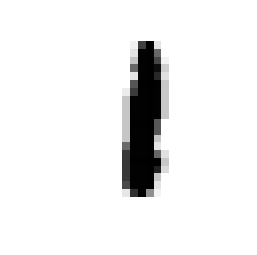

In [31]:
# defining a function for plotting the imaage

def plot_digit(data):
    image  = data.values.reshape(28,28)
    #print(image.shape)
    plt.imshow(image, interpolation = "nearest",cmap = mpl.cm.binary)
    plt.axis("off")
    
some_data = X_train.loc[[2500]]
plot_digit(some_data)
    

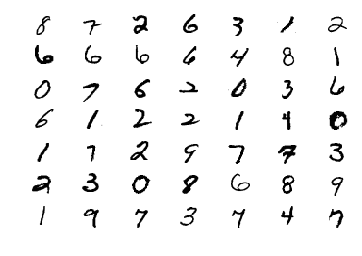

In [32]:
#plotting more images

for i in range(1,50):
    plt.subplot(7, 7, i)
    plot_digit(X_train.loc[[4999+i]])

### Multi-class Classification for MNIST

Two algoritms will be implemented in the multi-class classification version of the MNIST:
* SGD Classifier
* Random Forest Classifier

Implementing a multi-class classifier is actually quite straightforward.

#### Stochastic Gradient Descent

`SGD` is a binary classfier. For a multi-class classification scenario, SGD uses the `One vs. All` strategy. Using the `decision_function()` method, it is possible to get decision scores for all the classes.

In [37]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

sgd_model = SGDClassifier(random_state = 42)
cross_val_score(sgd_model,X_train, y_train, cv=5, scoring = "accuracy")

sgd_model.fit(X_train,y_train)

#generating predictions using cross vaidation
Y_train_sgd_cv_predict = cross_val_predict(sgd_model, X_train, y_train, cv=5)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

In [36]:
#Evaluating Performance
print("the shape of the predictor ",Y_train_sgd_cv_predict.shape) #this is a multiclass output

from sklearn.metrics import confusion_matrix
import pandas as pd

cm_train_sgd_cv = confusion_matrix(y_train,Y_train_sgd_cv_predict)

cm_train_sgd_cv_df = pd.DataFrame(cm_train_sgd_cv, columns = [0,1,2,3,4,5,6,7,8,9])

cm_train_sgd_cv_df #well done, this looks much neater



the shape of the predictor  (42000,)


,0,1,2,3,4,5,6,7,8,9
0,3925,0,59,43,6,24,36,4,34,1
1,0,4345,26,26,7,9,12,11,246,2
2,66,31,3500,128,55,15,75,82,216,9
3,39,21,150,3448,7,254,41,57,312,22
4,29,10,35,10,3624,14,50,59,153,88
5,90,15,36,229,51,2837,107,30,371,29
6,53,4,60,8,24,48,3873,9,57,1
7,36,17,53,50,38,14,8,4053,55,77
8,40,78,65,150,41,236,39,42,3366,6
9,49,16,41,105,325,137,2,819,411,2283


In [56]:
#saving results
Y_test = sgd_model.predict(X_test)
Y_test.shape

results = pd.Series(Y_test,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

#write out this dataframe as CSV
submission.to_csv("mnist_out_sg1.csv",index = False)

It is curious that 119 `1's` have been miscategorized as `8's`. Calls for further investigation.

Number of FP instances, SGD, Test Set  (119, 784)


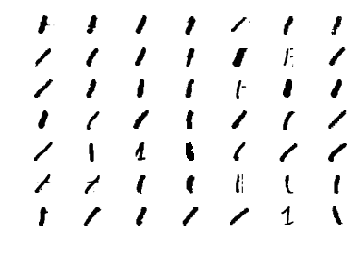

In [143]:
#SGD
FN_sgd_train = X_train[(Y_train_sgd_cv_predict == 8) & (y_train == 1)]
print("Number of FP instances, SGD, Test Set ",FN_sgd_train.shape) # m = 119

#Plotting
for i in range(1,50):
    plt.subplot(7, 7, i)
    plot_digit(FN_sgd_train[i])

Very interesting to note that a **thick or an ink-smudged** `1` is detected as an `8`

#### Random Forest Classifier

Unlike `SGD Classifier`, `Random Forest Classifier` natively supports multi-class.

In [60]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(n_estimators = 50,random_state = 42)

forest_model.fit(X_train,y_train)

#generating predictions using cross vaidation
Y_train_forest_cv_predict = cross_val_predict(forest_model, X_train, y_train, cv=5)


In [148]:
#Evaluating Performance
print("the shape of the predictor ",Y_train_forest_cv_predict.shape) #this is a multiclass output

cm_train_forest_cv = confusion_matrix(y_train,Y_train_forest_cv_predict)

cm_train_forest_cv_df = pd.DataFrame(cm_train_forest_cv, columns = [0,1,2,3,4,5,6,7,8,9])

cm_train_forest_cv_df #well done, this looks much neater

the shape of the predictor  (60000,)


,0,1,2,3,4,5,6,7,8,9
0,5842,1,10,2,7,5,20,2,30,4
1,1,6644,29,14,13,5,6,11,14,5
2,28,11,5751,32,29,4,18,34,42,9
3,8,7,92,5802,3,72,7,45,64,31
4,11,11,13,1,5653,0,22,10,13,108
5,22,11,12,70,13,5184,42,7,38,22
6,25,10,5,1,11,38,5813,0,15,0
7,9,27,66,7,35,1,0,6031,15,74
8,11,34,36,46,26,49,33,9,5554,53
9,22,12,13,77,91,24,5,53,42,5610


In [61]:
#Saving results for forest model


Y_test = forest_model.predict(X_test)
Y_test.shape

results = pd.Series(Y_test,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

#write out this dataframe as CSV
submission.to_csv("mnist_out_forest.csv",index = False)

Its immediately apparent that the number of entries that are mis-classified is **considerably lesser** than what it was in case of `SGD`

Its interesting to note that `4` has been mis-classified as `9` on 108 occasions. Zooming in a bit into this to understand this *visually*.

Number of mis-classifications of '4' as '9', Random Forest, Training Set  (108, 784)


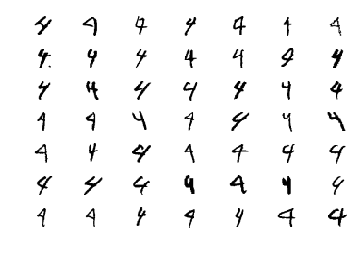

In [149]:
#RF
FN_forest_train = X_train[(Y_train_forest_cv_predict == 9) & (y_train == 4)]
print("Number of mis-classifications of '4' as '9', Random Forest, Training Set ",FN_forest_train.shape) # m = 108

#Plotting
for i in range(1,50):
    plt.subplot(7, 7, i)
    plot_digit(FN_forest_train[i])

A `4` that has been scribbled real quickly does resemble a `9`

#### Evaluating Performance on Test Set

##### SGD Classifier

In [151]:
Y_test_sgd = sgd_model.predict(X_test_prep)

cm_test_sgd = confusion_matrix(y_test,Y_test_sgd)

cm_test_sgd_df = pd.DataFrame(cm_test_sgd, columns = [0,1,2,3,4,5,6,7,8,9])

cm_test_sgd_df #well done, this looks much neater

,0,1,2,3,4,5,6,7,8,9
0,961,0,1,1,0,6,5,3,2,1
1,0,1095,6,2,0,4,4,1,22,1
2,11,4,912,21,13,4,13,9,42,3
3,6,1,20,902,0,32,5,8,22,14
4,2,3,7,0,898,2,9,6,10,45
5,9,4,1,41,13,755,18,7,30,14
6,13,3,9,1,8,22,896,1,5,0
7,4,6,23,4,5,1,0,945,1,39
8,11,9,8,19,8,37,12,9,840,21
9,6,6,3,13,21,9,0,23,11,917


##### Random Forest Classifier

In [152]:
Y_test_forest = forest_model.predict(X_test_prep)

cm_test_forest = confusion_matrix(y_test,Y_test_forest)

cm_test_forest_df = pd.DataFrame(cm_test_forest, columns = [0,1,2,3,4,5,6,7,8,9])

cm_test_forest_df #well done, this looks much neater

,0,1,2,3,4,5,6,7,8,9
0,971,0,1,0,0,1,4,1,2,0
1,0,1118,2,4,0,6,2,0,3,0
2,9,0,979,11,2,0,5,7,19,0
3,2,0,9,958,0,21,0,4,15,1
4,2,0,1,1,936,5,10,0,11,16
5,8,0,2,13,0,857,3,1,8,0
6,15,3,2,0,7,9,916,0,6,0
7,8,8,32,8,3,9,0,939,8,13
8,6,0,5,10,5,9,3,1,933,2
9,9,4,4,17,18,21,0,2,16,918


Random Forest performs exttremely well on the **test set**.

Interestingly `9` seems to have highest number of categories across which it is misclassified. Its misclassified as `3`,`4` and `5`.

Quickly zooming into the **21** instances when `9` is misclassified as `5`

Number of mis-classifications of '9' as '5', RF, Test Set  (21, 784)


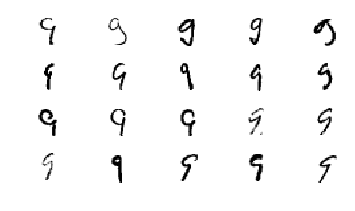

In [156]:
#RF
FN_forest_test = X_test[(Y_test_forest == 5) & (y_test == 9)]
print("Number of mis-classifications of '9' as '5', RF, Test Set ",FN_forest_test.shape) # m = 108

#Plotting
for i in range(1,21):
    plt.subplot(5, 5, i)
    plot_digit(FN_forest_test[i])




***